# Calibration of layer weights
Minimizing 
$$\frac{1}{N_{\text{evts}}} \sum_{i=1}^{N_{\text{evts}}} \left( \frac{ \sum_{l=1}^{28} w_l E_i^{\text{layer } l} }{E^{\text{gun}}_{i}} - 1 \right)^2$$

In [1]:
%load_ext autoreload
%autoreload 1
import sys
import os
sys.path.append("../..")

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import numpy as np
from tqdm.auto import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset

from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
%aimport ml.calibration.energy_distribution_from_weights
from ml.calibration.energy_distribution_from_weights import WeightedLayersComputations
from ml.plot_utils import plotLossPerEpoch

In [2]:
#device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device='cpu'

In [3]:
reader_sim = ClueNtupleReader("v41", "cmssw", "sim_proton_v46_patchMIP")
reader_data = ClueNtupleReader(reader_sim.version, reader_sim.clueParams, "data")
tensors_cpu = list(torch.load(os.path.join(reader_sim.pathToMLDatasetsFolder, "energyPerLayer", "energyPerLayer.pt")))
tensors_gpu = [tensor.to(device) for tensor in tensors_cpu]
full_dataset = TensorDataset(*tensors_gpu)

In [4]:
totalev = len(full_dataset)
ntrain = int(0.8*totalev)
ntest = totalev - ntrain

ntrainbatch = 200
#ntrainbatch = 2**14
ntestbatch = 100
train_dataset = full_dataset
#train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [ntrain, ntest])
trainloader = DataLoader(train_dataset, batch_size=ntrainbatch, shuffle=True)
#testloader = DataLoader(test_dataset, batch_size=ntestbatch, shuffle=True)

In [5]:
len(train_dataset)

353820

In [6]:
class Model(torch.nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):
        
        super().__init__()
        # initialize weights with random numbers
        #weights = torch.distributions.Uniform(0, 0.1).sample((3,))
        #weights = torch.ones(size=(28,),requires_grad=True,dtype=torch.float)
        weights = torch.normal(mean=torch.ones(size=(28,)), std=torch.ones(size=(28,))*0.5)
        # make weights torch parameters
        self.weights = torch.nn.Parameter(weights)
        #self.bias = torch.nn.Parameter(torch.tensor(10.*1e-3))
        
    def forward(self, X):
        """Implement function to be optimised.
        """
        batch_size = X.shape[0]
        output = X*self.weights.repeat(batch_size,1) # tensor (batchItem, layer) with weighted energy for each layer
        return torch.sum(output,dim=-1)# + self.bias # sum energies over all layer per item

In [7]:
model = Model().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

mse = torch.nn.MSELoss(reduction="sum")
def lossComputation(result:torch.Tensor, trueBeamEnergy:torch.Tensor):
    # return mse(result, data[1])  # Loss is MSE of E_estimate - E_beam
    return mse(result/trueBeamEnergy, torch.ones_like(result))  # Loss is MSE of E_estimate / E_beam wrt to 1


lossc,lossr = [],[]
epochs = []
#opt = torch.optim.Adam(model.parameters(), lr=0.001)
#opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#opt = torch.optim.SGD(model.parameters(), lr=1e-1)#, nesterov=True)

def train(epoch):
    model.train()
    #torch.cuda.empty_cache()
    #scheduler.step()
    loss = []
    for data in tqdm(trainloader):
            #data[0] = data[0].to(device)
            #data[1] = data[1].to(device)
            optimizer.zero_grad()
            result = model(data[0])

            lossc = lossComputation(result, data[1])

            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            #scheduler.batch_step()
    print( 'batches for train:',len(loss)) 
    print('train loss:',np.sum(np.array(loss)))
    return np.sum(np.array(loss))


In [8]:
nepoch=10
#os.makedirs(checkpoint_dir, exist_ok=True)
best_loss = 99999999
losst = []
lossv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    losst.append(train(epoch))
    #loss_epoch = evaluate(epoch)
    #lossv.append(loss_epoch)
    epochs.append(epoch)
    #checkpoint = {
    #'epoch': epoch + 1,
    #'state_dict': model.state_dict(),
    #'optimizer': optimizer.state_dict()
    #}
    
    #checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    #torch.save(checkpoint,
    #               os.path.join(checkpoint_dir,checkpoint_file ))
    # if loss_epoch < best_loss:
    #     best_loss = loss_epoch
    #     print('new best test loss:',best_loss)
        #torch.save(checkpoint,
        #           os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    # if ((epoch+1)%10 == 0):
    #     plotLossPerEpoch(epochs, losst, lossv)

epoch: 0


  0%|          | 0/1770 [00:00<?, ?it/s]

batches for train: 1770
train loss: 480.5074948053807
epoch: 1


  0%|          | 0/1770 [00:00<?, ?it/s]

batches for train: 1770
train loss: 297.4662411203608
epoch: 2


  0%|          | 0/1770 [00:00<?, ?it/s]

batches for train: 1770
train loss: 277.2719027060084
epoch: 3


  0%|          | 0/1770 [00:00<?, ?it/s]

batches for train: 1770
train loss: 272.51111123897135
epoch: 4


  0%|          | 0/1770 [00:00<?, ?it/s]

batches for train: 1770
train loss: 271.47600473463535
epoch: 5


  0%|          | 0/1770 [00:00<?, ?it/s]

batches for train: 1770
train loss: 271.20604423992336
epoch: 6


  0%|          | 0/1770 [00:00<?, ?it/s]

batches for train: 1770
train loss: 271.1183272525668
epoch: 7


  0%|          | 0/1770 [00:00<?, ?it/s]

batches for train: 1770
train loss: 271.0547614172101
epoch: 8


  0%|          | 0/1770 [00:00<?, ?it/s]

batches for train: 1770
train loss: 271.102585661225
epoch: 9


  0%|          | 0/1770 [00:00<?, ?it/s]

batches for train: 1770
train loss: 271.0885043218732


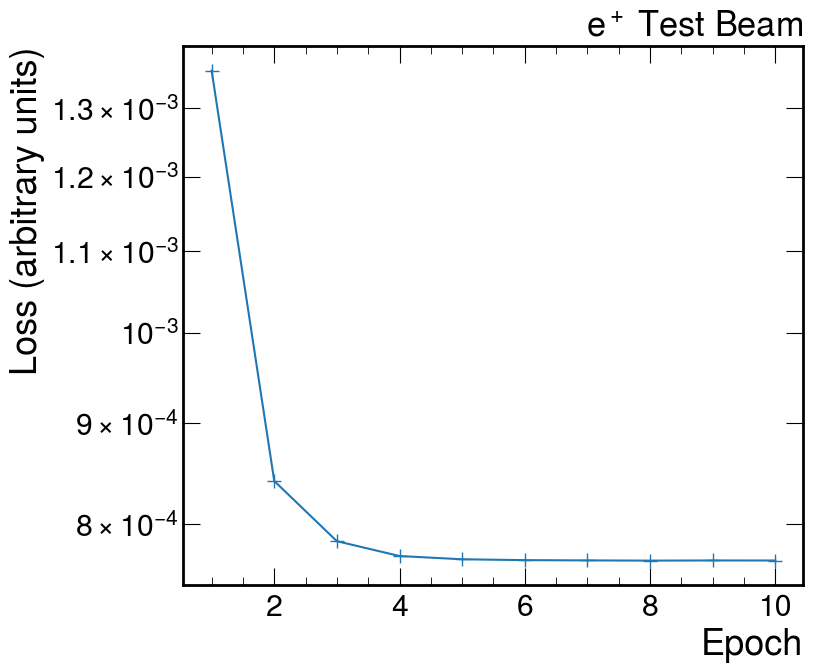

In [15]:
fig, ax = plt.subplots(figsize=(8, 7))

ax.plot(np.array(epochs)+1,np.array(losst)/len(train_dataset), '+-', label='Loss', markersize=10)
#ax.plot(np.array(epochs),np.array(lossv), '+-r', label='Testing loss', markersize=10)

#ax.set_ylim(7e-4, 2e-3)
from matplotlib.ticker import *

ax.set_yscale("log")
ax.yaxis.set_major_formatter(LogFormatterSciNotation(minor_thresholds=(5, 2)))
ax.yaxis.set_minor_formatter(LogFormatterSciNotation(minor_thresholds=(5, 2)))
plt.gca().get_yaxis().set_major_locator(AutoLocator())
# plt.gca().get_yaxis().set_major_formatter(ScalarFormatter())
# plt.gca().get_yaxis().set_minor_formatter(ScalarFormatter())
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (arbitrary units)")
hep.cms.lumitext("$e^+$ Test Beam")
#ax.legend()
plt.savefig("plots/loss-dedx-ml.pdf", bbox_inches="tight")

In [17]:
parameters = list(model.parameters())#[0].detach().cpu().numpy()
weightsAsDict = dict(zip(range(1, 28+1), parameters[0].detach().cpu().numpy()))
parameters[0]#, parameters[1] 

Parameter containing:
tensor([0.9399, 1.0322, 0.9740, 1.0065, 0.9783, 1.0243, 0.9782, 1.0220, 0.9690,
        1.0218, 0.9722, 1.0106, 0.9757, 0.9961, 0.9633, 1.0079, 0.9826, 0.9878,
        0.9835, 1.0519, 1.0040, 1.0720, 1.0650, 1.1075, 1.1342, 1.1542, 1.1409,
        2.2136], requires_grad=True)

In [18]:
weightedComp_sim = WeightedLayersComputations(weightsAsDict, reader_sim)
weightedComp_data = WeightedLayersComputations(weightsAsDict, reader_data)

In [19]:
# import importlib
# import ml.calibration.energy_distribution_from_weights
# importlib.reload(ml.calibration.energy_distribution_from_weights).WeightedLayersComputations.plotDeDxWeights(weightedComp)
# None

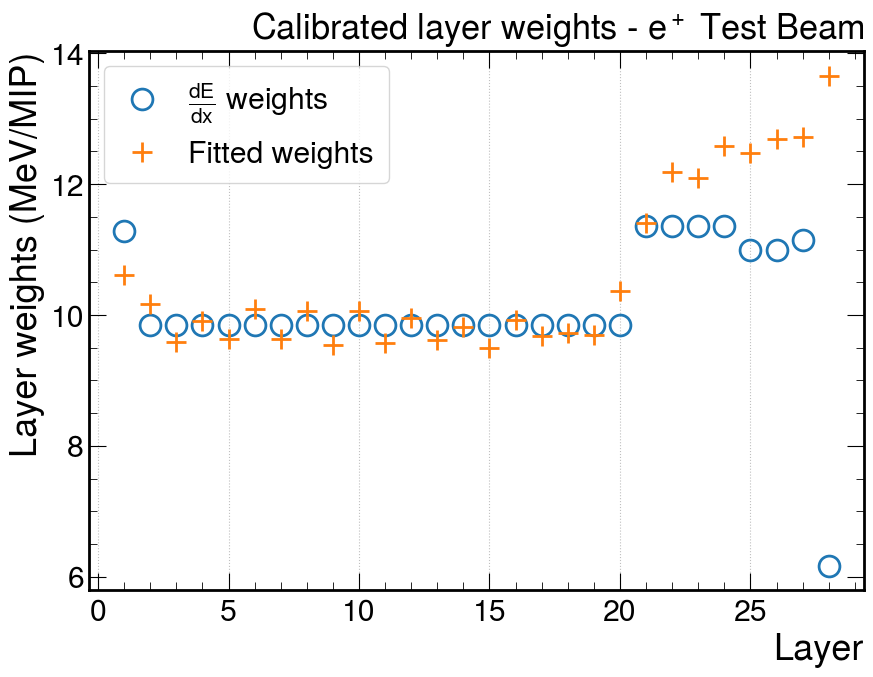

In [20]:
weightedComp_sim.plotDeDxWeights()
None # NB : in longitudinal profiles, even layer have a dip, odd have a bump
plt.savefig("plots/weights-dedx-ml.pdf", bbox_inches="tight")

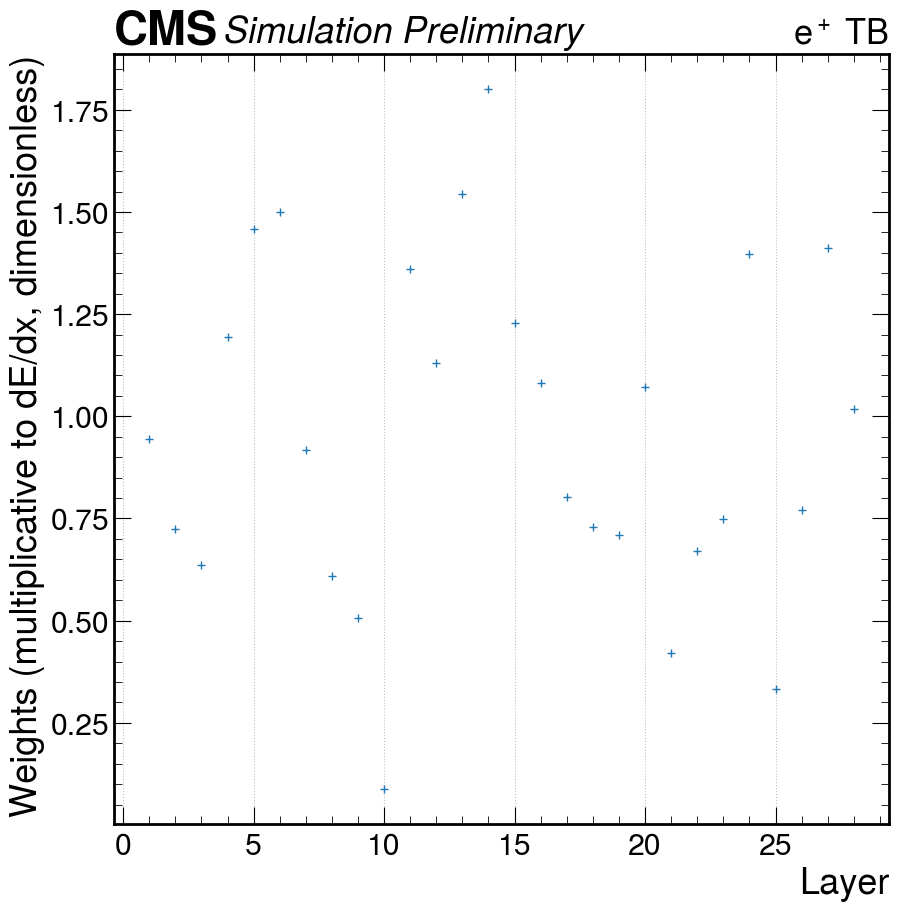

In [ ]:
weightedComp_sim.plotRelativeWeights()
None

In [21]:
weightedComp_sim.compute()


Histogramming with weighted layers:   0%|          | 0/359937 [00:00<?, ?it/s]

In [22]:
weightedComp_data.compute()

Histogramming with weighted layers:   0%|          | 0/272855 [00:00<?, ?it/s]

Text(0, 1, 'Constant term C (%)')

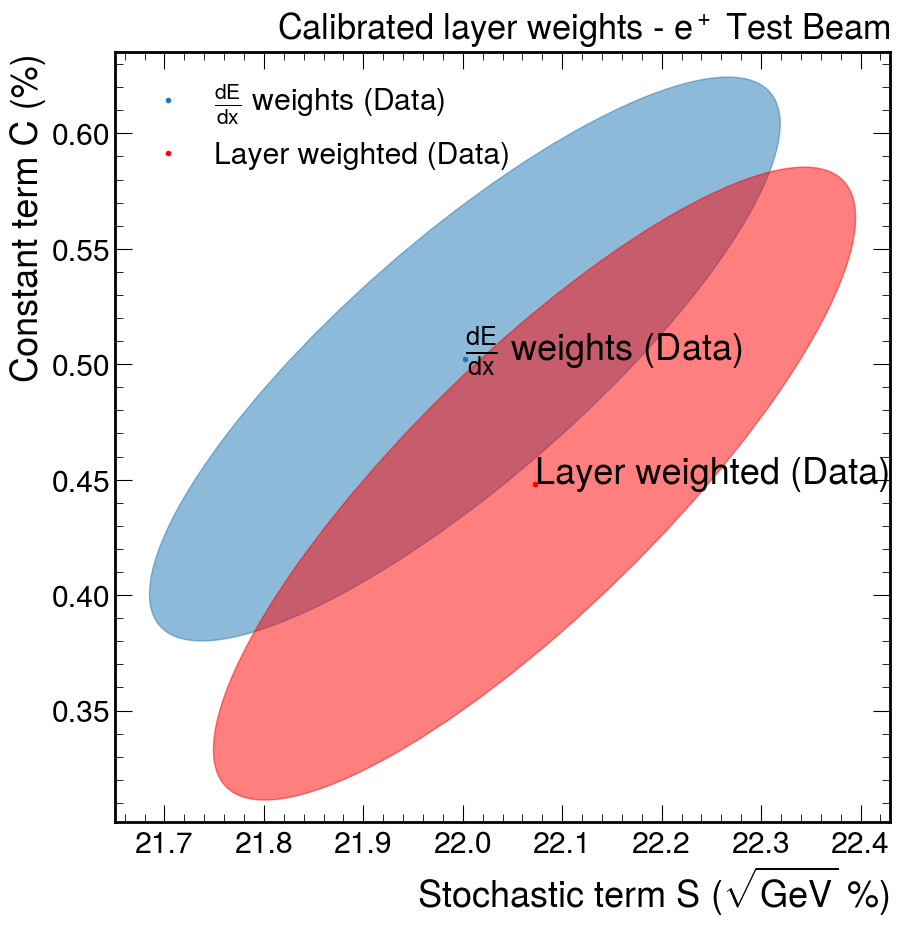

In [23]:
from energy_resolution.sigma_over_e import SigmaOverEPlotElement, plotSCAsEllipse, plotSigmaOverMean, sigmaOverE_fitFunction
import mplhep as hep
import dataclasses
plotSCAsEllipse([
    dataclasses.replace(reader_data.loadSigmaOverEResults("rechits"), legend="$\\frac{dE}{dx}$ weights (Data)"),
    SigmaOverEPlotElement(legend="Layer weighted (Data)", fitResult=weightedComp_data.sigmaOverE, color="red")
])
#hep.cms.text("Preliminary")
hep.cms.lumitext("Calibrated layer weights - $e^+$ Test Beam")
plt.xlabel("Stochastic term S ($\sqrt{GeV}$ %)")
plt.ylabel("Constant term C (%)")

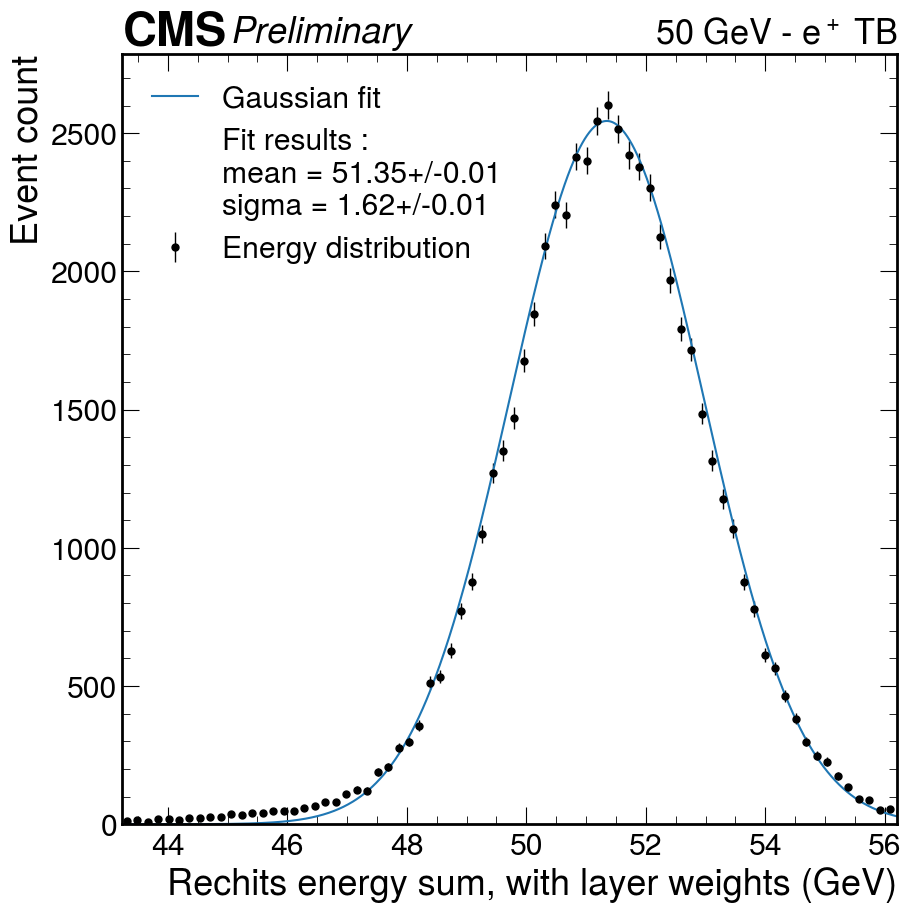

In [ ]:
weightedComp_data.sigmaOverEComputation.plotFitResult(50)

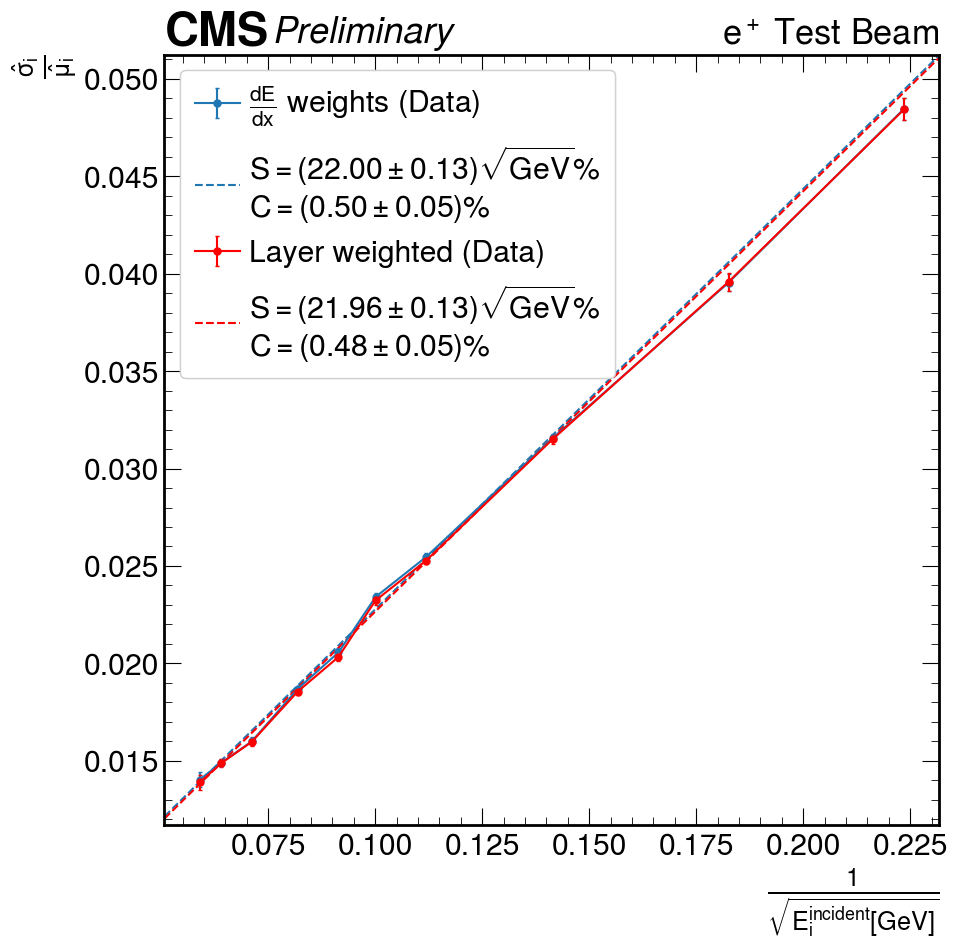

In [ ]:
plotSigmaOverMean([
    dataclasses.replace(reader_data.loadSigmaOverEResults("rechits"), legend="$\\frac{dE}{dx}$ weights (Data)"),
    SigmaOverEPlotElement(legend="Layer weighted (Data)", fitResult=weightedComp_data.sigmaOverE, color="red", fitFunction=sigmaOverE_fitFunction,
                          dataPoints={beamEnergy : result.sigma / result.mu for beamEnergy, result in weightedComp_data.sigmaOverEComputation.results.items()})
    ], xMode="1/sqrt(E)", plotFit=True)
None

<Axes: xlabel='$S (\\sqrt{GeV} \\%)$', ylabel='C (%)'>

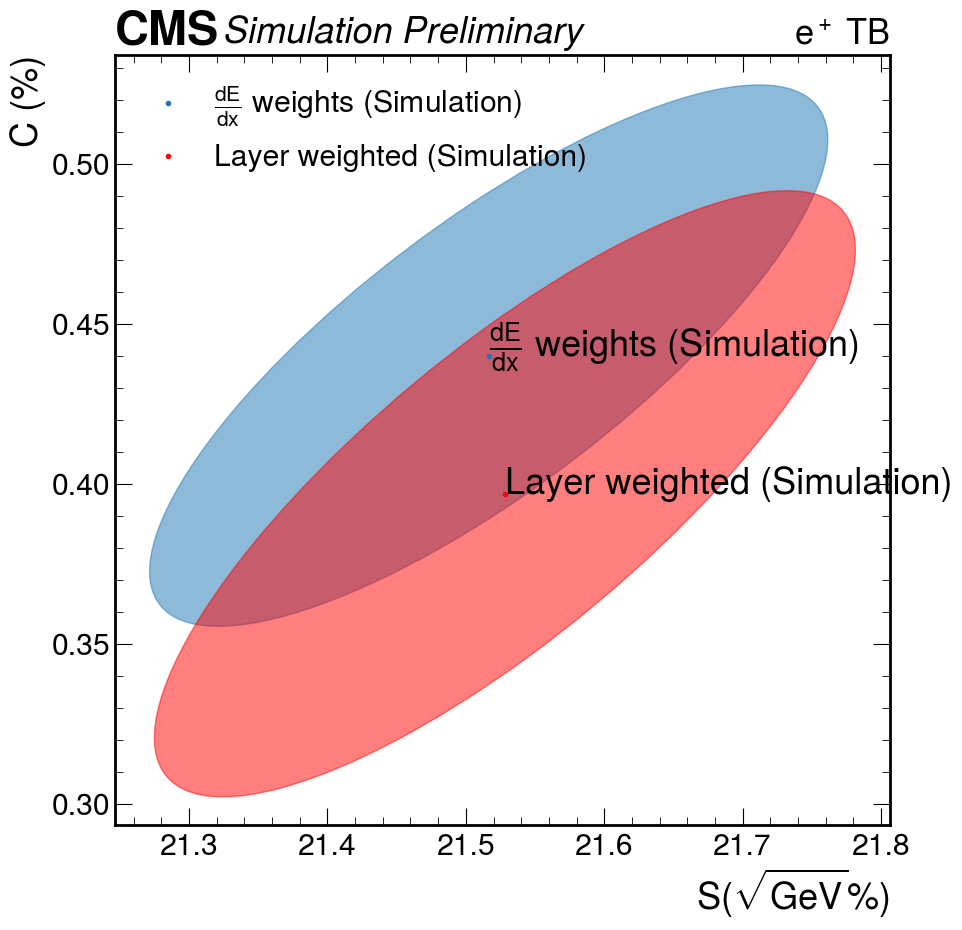

In [ ]:
plotSCAsEllipse([
    dataclasses.replace(reader_sim.loadSigmaOverEResults("rechits"), legend="$\\frac{dE}{dx}$ weights (Simulation)"),
    SigmaOverEPlotElement(legend="Fitted weights (Simulation)", fitResult=weightedComp_sim.sigmaOverE, color="red")
])
#hep.cms.text("Preliminary")
hep.cms.lumitext("Calibrated layer weights - $e^+$ Test Beam")
plt.xlabel("Stochastic term S ($\sqrt{GeV}$ %)")
plt.ylabel("Constant term C (%)")

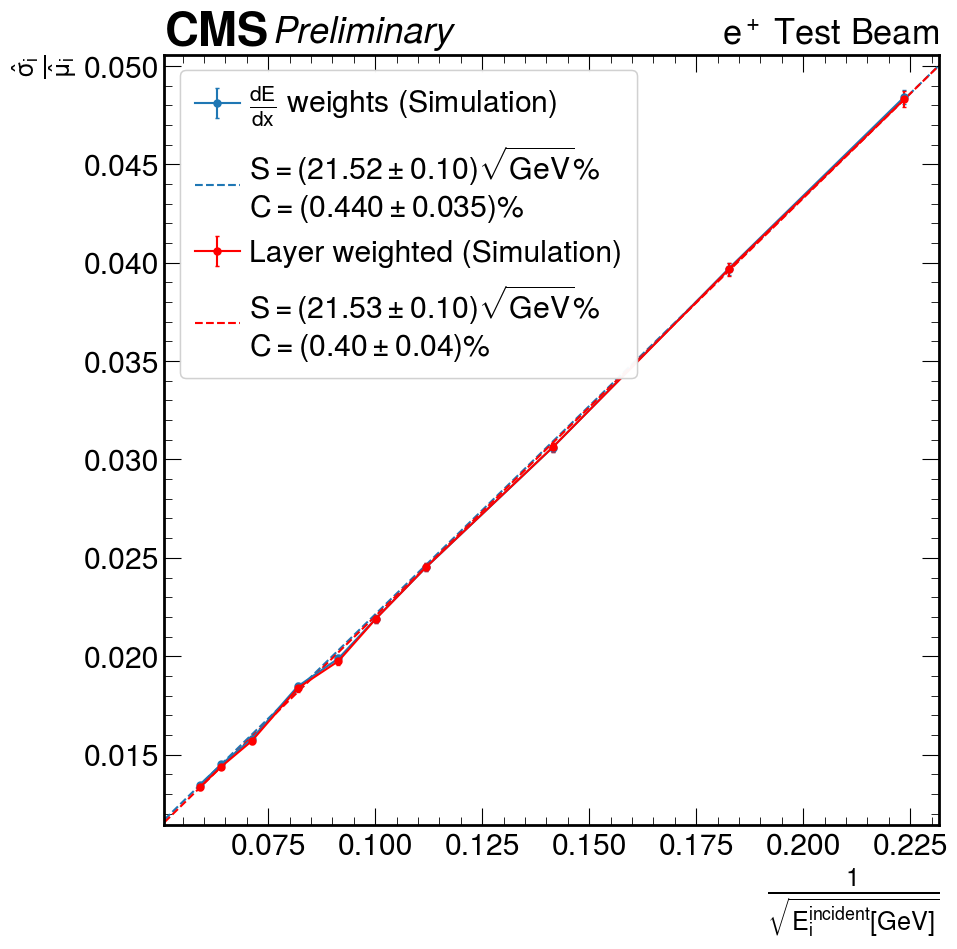

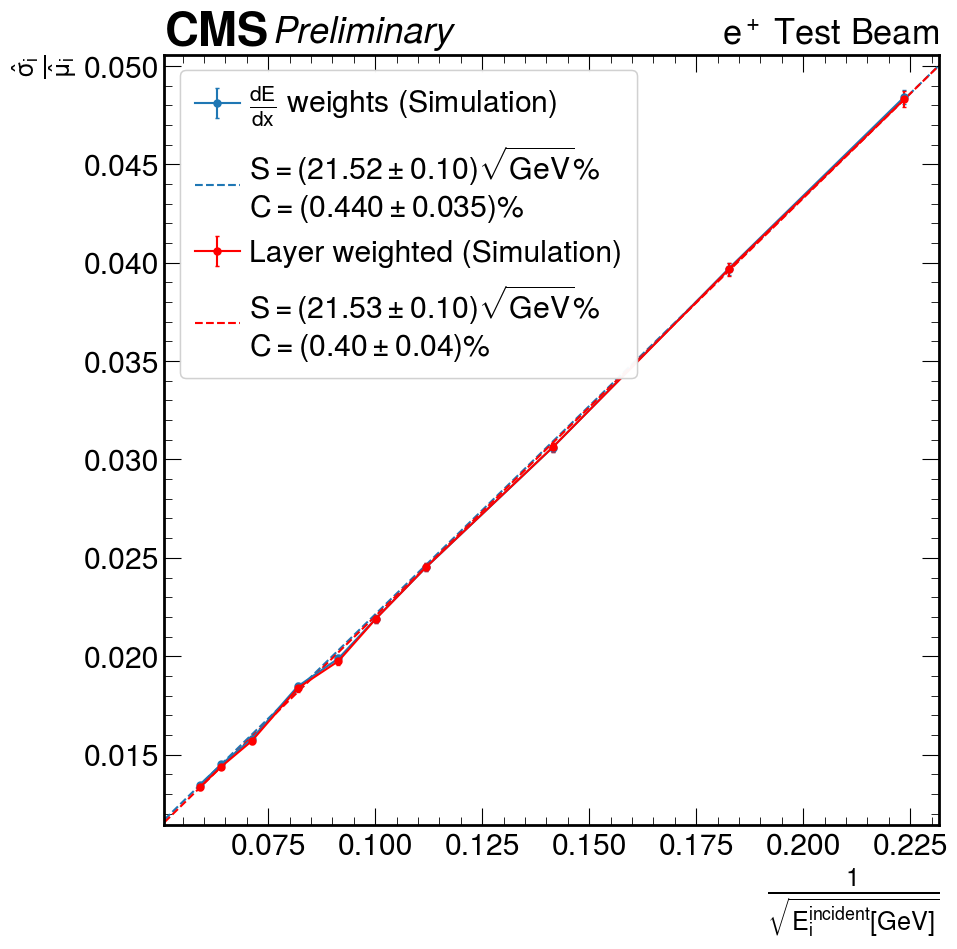

In [ ]:
plotSigmaOverMean([
    dataclasses.replace(reader_sim.loadSigmaOverEResults("rechits"), legend="$\\frac{dE}{dx}$ weights (Simulation)"),
    SigmaOverEPlotElement(legend="Layer weighted (Simulation)", fitResult=weightedComp_sim.sigmaOverE, color="red", fitFunction=sigmaOverE_fitFunction,
                          dataPoints={beamEnergy : result.sigma / result.mu for beamEnergy, result in weightedComp_sim.sigmaOverEComputation.results.items()})
    ], xMode="1/sqrt(E)", plotFit=True)
None

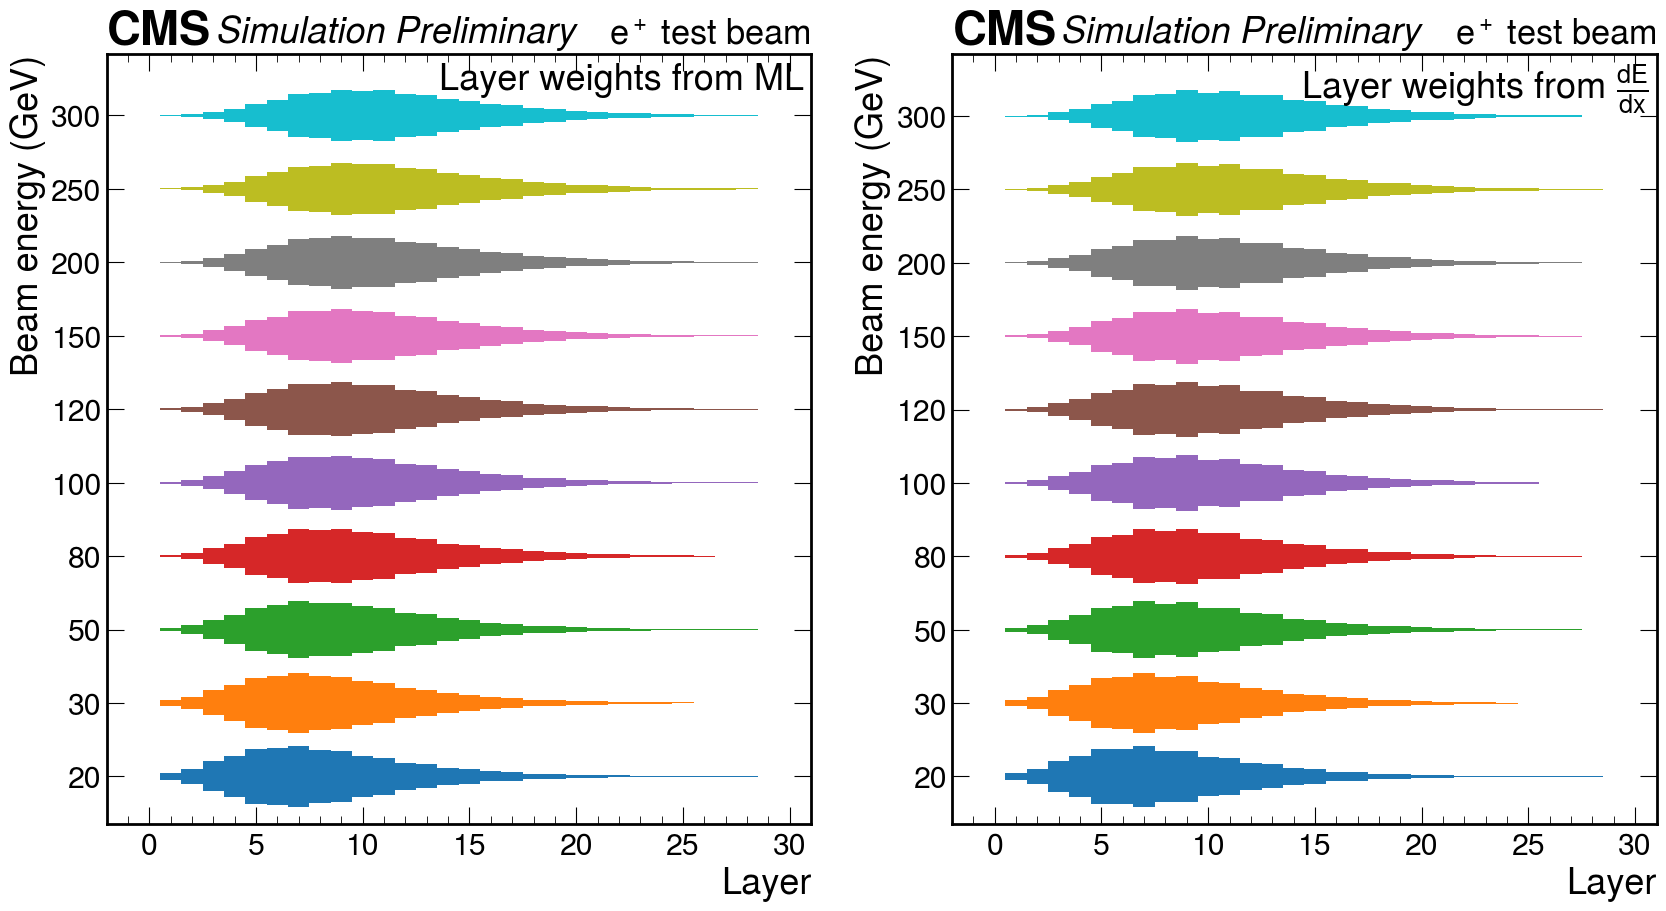

In [ ]:
weightedComp.plotViolin()
None

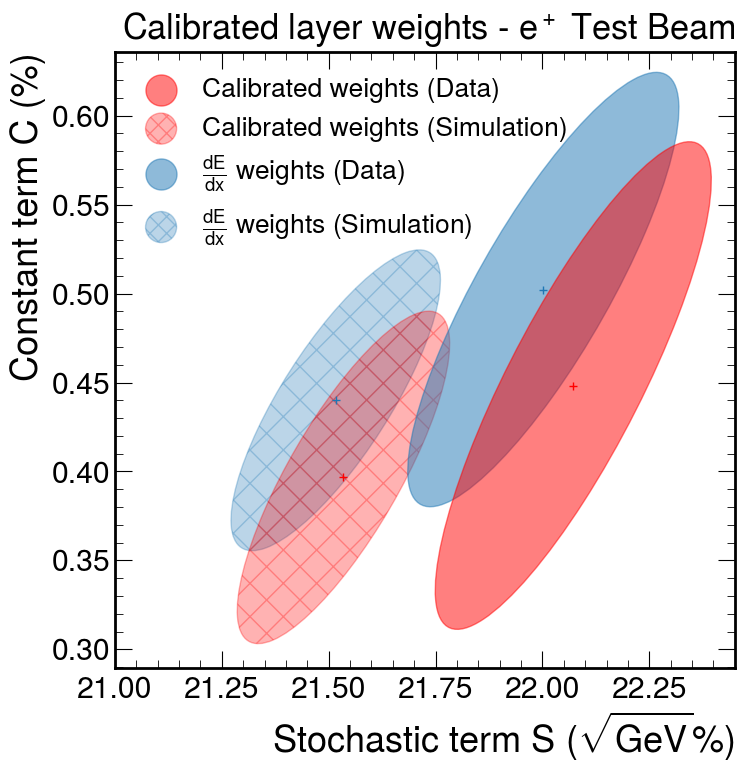

In [28]:
import functools
from energy_resolution.sigma_over_e import plotEllipse
plotElts_data = [
    dataclasses.replace(reader_data.loadSigmaOverEResults("rechits"), legend="$\\frac{dE}{dx}$ weights (Data)"),
    SigmaOverEPlotElement(legend="Calibrated weights (Data)", fitResult=weightedComp_data.sigmaOverE, color="red")
]
plotElts_sim = [
    dataclasses.replace(reader_sim.loadSigmaOverEResults("rechits"), legend="$\\frac{dE}{dx}$ weights (Simulation)"),
    SigmaOverEPlotElement(legend="Calibrated weights (Simulation)", fitResult=weightedComp_sim.sigmaOverE, color="red")
]
fig, ax = plt.subplots(figsize=(8, 8))
def plotEllipseFromPlotElts(plotElement:SigmaOverEPlotElement, sim=False, **ellipse_kwargs):
    S_scaled, C_scaled = plotElement.fitResult.S*100, plotElement.fitResult.C*100
    x, y = S_scaled.nominal_value, C_scaled.nominal_value
    label = None if sim else plotElement.legend
    ax.plot([x], [y], "+", label=label, color=plotElement.color)
    ax.add_patch(plotEllipse(S_scaled, C_scaled, ellipse_kwargs=dict(color=plotElement.color, alpha=0.5)|ellipse_kwargs))
    if not sim:
        #ax.annotate(plotElement.legend, xy=(x, y))
        pass

legend_handle_bound = functools.partial(plt.scatter, [], [], s=500, marker='o', alpha=0.5,)
legend_handles = []
for plotElement_data, plotElement_sim in zip(plotElts_data, plotElts_sim):
    plotEllipseFromPlotElts(plotElement_data)
    legend_handles.append(legend_handle_bound(label=plotElement_data.legend, color=plotElement_data.color))
    plotEllipseFromPlotElts(plotElement_sim, sim=True, hatch="x", alpha=0.3, zorder=-1)
    legend_handles.append(legend_handle_bound(label=plotElement_sim.legend, color=plotElement_sim.color, alpha=0.3,  hatch="xx"))

#hep.cms.text("Preliminary", ax=ax)
hep.cms.lumitext(f"Calibrated layer weights - $e^+$ Test Beam", ax=ax)
ax.set_xlabel(r"Stochastic term S $(\sqrt{GeV} \%)$")
ax.set_ylabel(r"Constant term C (%)")
ax.set_xlim(left=21)

ax.legend(handles=[legend_handles[idx] for idx in [2, 3, 0, 1]], prop={'size': 19})
#ax.annotate("Rechits", (21.4, 0.55), color="tab:blue")
plt.savefig("plots/dedx-ml-energy-resolution-ellipses.png", bbox_inches="tight", dpi=200) # for some reasons hatches don't work in pdf